# London neighbourhoods project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from urllib.request import urlopen
from bs4 import BeautifulSoup as bsoup
import requests
import lxml
from urllib.request import urlopen

import json
from geopy.geocoders import Nominatim
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
!conda install -c conda-forge folium=0.5.0 --yes
import folium
print('done')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    branca-0.4.0               |             py_0          26 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    altair-4.0.1               |             py_0         575 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.0 MB

The following NEW packages will be 

First, obtain data on London neighborhood from the web

In [2]:
link = 'https://en.wikipedia.org/wiki/List_of_London_boroughs'
link = requests.get(link).text
scrapped = bsoup(link, 'lxml')


listboroughs = []
for row in scrapped.find ('table', class_='wikitable sortable').find_all('tr')[1::]:
    rows = row.find_all(['td'])
    row1 = rows[0]
    row8 = rows[8]
    try:
        borough = row1.get_text()
        borough = borough.split('[')
        borough = borough[0]
        borough = borough.strip()
                
        ll = row8.get_text()
        ll=ll.split('/')
        latitude_longitude = ll[2]
        latitude_longitude = latitude_longitude.split('(')
        latitude_longitude = latitude_longitude[0]
        latitude_longitude = latitude_longitude.split(';')
        latitude = latitude_longitude[0]
        latitude=latitude.strip()
        longitude = latitude_longitude[1]
        longitude=longitude.strip()
        longitude = longitude.replace(u'\ufeff', '')
        latitude = float(latitude)
        longitude = float(longitude)
        listboroughs.append((borough, latitude, longitude))
    except IndexError:pass
    

In [81]:
listboroughsdf = pd.DataFrame(listboroughs, columns = ['Borough', 'Latitude', 'Longitude'])
listboroughsdf.head()

,Borough,Latitude,Longitude
0,Barking and Dagenham,51.5607,0.1557
1,Barnet,51.6252,-0.1517
2,Bexley,51.4549,0.1505
3,Brent,51.5588,-0.2817
4,Bromley,51.4039,0.0198


In [82]:
listboroughsdf.rename(columns={"Borough": "Neighborhood"})

,Neighborhood,Latitude,Longitude
0,Barking and Dagenham,51.5607,0.1557
1,Barnet,51.6252,-0.1517
2,Bexley,51.4549,0.1505
3,Brent,51.5588,-0.2817
4,Bromley,51.4039,0.0198
5,Camden,51.5290,-0.1255
6,Croydon,51.3714,-0.0977
7,Ealing,51.5130,-0.3089
8,Enfield,51.6538,-0.0799
9,Greenwich,51.4892,0.0648


Find London's coordinates for mapping

In [83]:
latitude=51.5074
longitude=0.1357

Let's try to explore boroughs on a folium map. 

In [84]:
londonmap = folium.Map(location=[latitude, longitude], zoom_start = 12)
for lat, lng, label in zip(listboroughsdf['Latitude'], listboroughsdf['Longitude'], listboroughsdf['Borough']):
    label=folium.Popup(label, parse_html = True)
    folium.CircleMarker(
    [lat, lng],
    radius = 5,
    popup = label,
    color = 'blue',
    fill = True,
    fill_color='#3186cc',
    fill_opacity=0.7,
    parse_html=False).add_to(londonmap)
londonmap

After obtaining a dataset of boroughs with their geographical coordinates, we can make an API call to get venues in the boroughs. The chosen limit is 2000 with a larger radius. 

In [10]:
CLIENT_ID = '25AENR21N5KJVMIEUFKQKTJLXEYXUDRI11X0MP4VQGUYTHDA' # your Foursquare ID
CLIENT_SECRET = 'KTMRSQJR5Y14FQPZUWPYT1H1KWVJTS1NZHJB1NXELSVCPP1P' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 2000
radius = 50000

In [11]:
def getvenues(names, latitudes, longitudes, radius=50000):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
       # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [14]:
venues = getvenues(names=listboroughsdf['Borough'],
                                   latitudes=listboroughsdf['Latitude'],
                                   longitudes=listboroughsdf['Longitude']
                                  )

Barking and Dagenham
Barnet
Bexley
Brent
Bromley
Camden
Croydon
Ealing
Enfield
Greenwich
Hackney
Hammersmith and Fulham
Haringey
Harrow
Havering
Hillingdon
Hounslow
Islington
Kensington and Chelsea
Kingston upon Thames
Lambeth
Lewisham
Merton
Newham
Redbridge
Richmond upon Thames
Southwark
Sutton
Tower Hamlets
Waltham Forest
Wandsworth
Westminster


In [15]:
venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Barking and Dagenham,51.5607,0.1557,Better London Aquatics Centre,51.540252,-0.010536,Pool
1,Barking and Dagenham,51.5607,0.1557,Lee Valley VeloPark,51.550345,-0.016796,Athletics & Sports
2,Barking and Dagenham,51.5607,0.1557,Secret Cinema,51.515953,0.007427,Movie Theater
3,Barking and Dagenham,51.5607,0.1557,Sodo Pizza Cafe - Walthamstow,51.586197,-0.020491,Pizza Place
4,Barking and Dagenham,51.5607,0.1557,Crate Brewery,51.542973,-0.022063,Brewery


In [18]:
venues.shape

(3200, 7)

In [19]:
venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Barking and Dagenham,100,100,100,100,100,100
Barnet,100,100,100,100,100,100
Bexley,100,100,100,100,100,100
Brent,100,100,100,100,100,100
Bromley,100,100,100,100,100,100
Camden,100,100,100,100,100,100
Croydon,100,100,100,100,100,100
Ealing,100,100,100,100,100,100
Enfield,100,100,100,100,100,100


In [21]:
# one hot encoding
london_onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
london_onehot['Neighborhood'] = venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]

london_onehot.head()

,Neighborhood,Airport Lounge,Art Gallery,Art Museum,Athletics & Sports,BBQ Joint,Bakery,Bar,Beer Bar,Beer Store,...,Sushi Restaurant,Tennis Stadium,Theater,Trail,Turkish Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio
0,Barking and Dagenham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Barking and Dagenham,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Barking and Dagenham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Barking and Dagenham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Barking and Dagenham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
london_grouped = london_onehot.groupby('Neighborhood').mean().reset_index()
london_grouped

,Neighborhood,Airport Lounge,Art Gallery,Art Museum,Athletics & Sports,BBQ Joint,Bakery,Bar,Beer Bar,Beer Store,...,Sushi Restaurant,Tennis Stadium,Theater,Trail,Turkish Restaurant,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio
0,Barking and Dagenham,0.00,0.01,0.01,0.01,0.01,0.01,0.02,0.01,0.01,...,0.01,0.00,0.05,0.00,0.01,0.00,0.01,0.00,0.01,0.00
1,Barnet,0.00,0.02,0.00,0.01,0.00,0.01,0.00,0.00,0.00,...,0.01,0.00,0.02,0.01,0.01,0.00,0.01,0.00,0.01,0.01
2,Bexley,0.00,0.01,0.03,0.01,0.01,0.01,0.02,0.01,0.02,...,0.01,0.00,0.05,0.00,0.00,0.00,0.01,0.01,0.01,0.00
3,Brent,0.00,0.02,0.02,0.00,0.00,0.00,0.01,0.00,0.00,...,0.00,0.00,0.01,0.01,0.00,0.01,0.00,0.00,0.01,0.01
4,Bromley,0.00,0.02,0.03,0.00,0.01,0.00,0.02,0.01,0.02,...,0.01,0.00,0.04,0.00,0.00,0.00,0.01,0.01,0.00,0.00
5,Camden,0.00,0.02,0.02,0.00,0.00,0.01,0.01,0.00,0.00,...,0.01,0.00,0.04,0.00,0.00,0.00,0.01,0.01,0.01,0.01
6,Croydon,0.00,0.02,0.05,0.00,0.00,0.00,0.01,0.01,0.02,...,0.01,0.01,0.04,0.00,0.00,0.00,0.00,0.01,0.00,0.00
7,Ealing,0.01,0.02,0.03,0.00,0.00,0.00,0.01,0.00,0.00,...,0.00,0.01,0.01,0.00,0.00,0.01,0.00,0.00,0.01,0.01
8,Enfield,0.00,0.01,0.00,0.01,0.01,0.01,0.01,0.00,0.00,...,0.01,0.00,0.02,0.01,0.01,0.00,0.01,0.00,0.01,0.01
9,Greenwich,0.00,0.01,0.02,0.01,0.01,0.01,0.02,0.01,0.02,...,0.01,0.00,0.05,0.00,0.00,0.00,0.01,0.01,0.01,0.00


In [25]:
num_top_venues = 10

for hood in london_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = london_grouped[london_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Barking and Dagenham----
               venue  freq
0              Hotel  0.08
1            Theater  0.05
2        Coffee Shop  0.05
3       Cocktail Bar  0.05
4               Park  0.04
5                Pub  0.04
6  Indian Restaurant  0.02
7              Canal  0.02
8      Grocery Store  0.02
9     Scenic Lookout  0.02


----Barnet----
               venue  freq
0               Park  0.10
1              Hotel  0.06
2        Coffee Shop  0.05
3       Cocktail Bar  0.05
4                Pub  0.04
5  Indian Restaurant  0.03
6        Pizza Place  0.03
7             Garden  0.03
8             Lounge  0.02
9          Bookstore  0.02


----Bexley----
          venue  freq
0         Hotel  0.08
1          Park  0.06
2  Cocktail Bar  0.05
3       Theater  0.05
4   Coffee Shop  0.05
5           Pub  0.04
6        Garden  0.03
7    Art Museum  0.03
8           Bar  0.02
9        Market  0.02


----Brent----
               venue  freq
0               Park  0.13
1              Hotel  0.12
2   

In [26]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [50]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = london_grouped['Neighborhood']

for ind in np.arange(london_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(32)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barking and Dagenham,Hotel,Theater,Cocktail Bar,Coffee Shop,Park,Pub,Indian Restaurant,Nature Preserve,Canal,Performing Arts Venue
1,Barnet,Park,Hotel,Coffee Shop,Cocktail Bar,Pub,Indian Restaurant,Pizza Place,Garden,Lounge,Grocery Store
2,Bexley,Hotel,Park,Theater,Cocktail Bar,Coffee Shop,Pub,Garden,Art Museum,Canal,Beer Store
3,Brent,Park,Hotel,Cocktail Bar,Grocery Store,Bookstore,Botanical Garden,Garden,Department Store,Pizza Place,Indian Restaurant
4,Bromley,Hotel,Park,Cocktail Bar,Theater,Coffee Shop,Art Museum,Beer Store,Scenic Lookout,Liquor Store,Brewery
5,Camden,Hotel,Park,Cocktail Bar,Theater,Indian Restaurant,Bookstore,Grocery Store,Coffee Shop,Department Store,Garden
6,Croydon,Hotel,Park,Art Museum,Theater,Cocktail Bar,Café,Boutique,Pizza Place,Plaza,Bookstore
7,Ealing,Park,Hotel,Cocktail Bar,Garden,Art Museum,Bookstore,Botanical Garden,Department Store,Café,Pizza Place
8,Enfield,Park,Cocktail Bar,Coffee Shop,Hotel,Pub,Garden,Indian Restaurant,Grocery Store,Nature Preserve,Climbing Gym
9,Greenwich,Hotel,Park,Cocktail Bar,Theater,Coffee Shop,Pub,Garden,Canal,Market,Brewery


### Clustering

In [51]:
kclusters = 4

london_grouped_clustering = london_grouped.drop('Neighborhood', 1)


kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(london_grouped_clustering)


kmeans.labels_[0:50] 

array([2, 0, 2, 3, 2, 1, 1, 3, 0, 2, 2, 3, 0, 3, 2, 3, 3, 2, 1, 3, 1, 2,
       3, 2, 2, 3, 2, 3, 2, 0, 1, 1], dtype=int32)

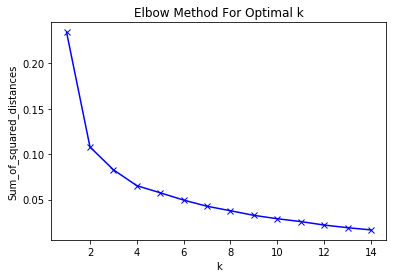

In [52]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(london_grouped_clustering)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

4 is a good number of clusters for London boroughs. 

In [53]:
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barking and Dagenham,Hotel,Theater,Cocktail Bar,Coffee Shop,Park,Pub,Indian Restaurant,Nature Preserve,Canal,Performing Arts Venue
1,Barnet,Park,Hotel,Coffee Shop,Cocktail Bar,Pub,Indian Restaurant,Pizza Place,Garden,Lounge,Grocery Store
2,Bexley,Hotel,Park,Theater,Cocktail Bar,Coffee Shop,Pub,Garden,Art Museum,Canal,Beer Store
3,Brent,Park,Hotel,Cocktail Bar,Grocery Store,Bookstore,Botanical Garden,Garden,Department Store,Pizza Place,Indian Restaurant
4,Bromley,Hotel,Park,Cocktail Bar,Theater,Coffee Shop,Art Museum,Beer Store,Scenic Lookout,Liquor Store,Brewery


In [55]:

#neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
#neighborhoods_venues_sorted.drop('Cluster Labels', 0)

neighborhoods_venues_sorted.insert(3, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted.head()


ValueError: cannot insert Cluster Labels, already exists

In [56]:
neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,Cluster Labels,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barking and Dagenham,Hotel,Theater,2,Cocktail Bar,Coffee Shop,Park,Pub,Indian Restaurant,Nature Preserve,Canal,Performing Arts Venue
1,Barnet,Park,Hotel,0,Coffee Shop,Cocktail Bar,Pub,Indian Restaurant,Pizza Place,Garden,Lounge,Grocery Store
2,Bexley,Hotel,Park,2,Theater,Cocktail Bar,Coffee Shop,Pub,Garden,Art Museum,Canal,Beer Store
3,Brent,Park,Hotel,3,Cocktail Bar,Grocery Store,Bookstore,Botanical Garden,Garden,Department Store,Pizza Place,Indian Restaurant
4,Bromley,Hotel,Park,2,Cocktail Bar,Theater,Coffee Shop,Art Museum,Beer Store,Scenic Lookout,Liquor Store,Brewery


In [59]:
neighborhoods_venues_sorted.reset_index(drop=True)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,Cluster Labels,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barking and Dagenham,Hotel,Theater,2,Cocktail Bar,Coffee Shop,Park,Pub,Indian Restaurant,Nature Preserve,Canal,Performing Arts Venue
1,Barnet,Park,Hotel,0,Coffee Shop,Cocktail Bar,Pub,Indian Restaurant,Pizza Place,Garden,Lounge,Grocery Store
2,Bexley,Hotel,Park,2,Theater,Cocktail Bar,Coffee Shop,Pub,Garden,Art Museum,Canal,Beer Store
3,Brent,Park,Hotel,3,Cocktail Bar,Grocery Store,Bookstore,Botanical Garden,Garden,Department Store,Pizza Place,Indian Restaurant
4,Bromley,Hotel,Park,2,Cocktail Bar,Theater,Coffee Shop,Art Museum,Beer Store,Scenic Lookout,Liquor Store,Brewery
5,Camden,Hotel,Park,1,Cocktail Bar,Theater,Indian Restaurant,Bookstore,Grocery Store,Coffee Shop,Department Store,Garden
6,Croydon,Hotel,Park,1,Art Museum,Theater,Cocktail Bar,Café,Boutique,Pizza Place,Plaza,Bookstore
7,Ealing,Park,Hotel,3,Cocktail Bar,Garden,Art Museum,Bookstore,Botanical Garden,Department Store,Café,Pizza Place
8,Enfield,Park,Cocktail Bar,0,Coffee Shop,Hotel,Pub,Garden,Indian Restaurant,Grocery Store,Nature Preserve,Climbing Gym
9,Greenwich,Hotel,Park,2,Cocktail Bar,Theater,Coffee Shop,Pub,Garden,Canal,Market,Brewery


In [75]:


listboroughsdf.rename(columns = {'Borough':'Neighborhood'}, inplace = True)
listboroughsdf.set_index('Neighborhood')
listboroughsdf.head()


,Neighborhood,Latitude,Longitude
0,Barking and Dagenham,51.5607,0.1557
1,Barnet,51.6252,-0.1517
2,Bexley,51.4549,0.1505
3,Brent,51.5588,-0.2817
4,Bromley,51.4039,0.0198


In [79]:
#london_merged = listboroughsdf
#london_merged = london_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
#london_merged.head() 
neighborhoods_venues_sorted.set_index('Neighborhood')

london_merged = pd.merge(neighborhoods_venues_sorted, listboroughsdf, on='Neighborhood')

london_merged.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,Cluster Labels,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Latitude,Longitude
0,Barking and Dagenham,Hotel,Theater,2,Cocktail Bar,Coffee Shop,Park,Pub,Indian Restaurant,Nature Preserve,Canal,Performing Arts Venue,51.5607,0.1557
1,Barnet,Park,Hotel,0,Coffee Shop,Cocktail Bar,Pub,Indian Restaurant,Pizza Place,Garden,Lounge,Grocery Store,51.6252,-0.1517
2,Bexley,Hotel,Park,2,Theater,Cocktail Bar,Coffee Shop,Pub,Garden,Art Museum,Canal,Beer Store,51.4549,0.1505
3,Brent,Park,Hotel,3,Cocktail Bar,Grocery Store,Bookstore,Botanical Garden,Garden,Department Store,Pizza Place,Indian Restaurant,51.5588,-0.2817
4,Bromley,Hotel,Park,2,Cocktail Bar,Theater,Coffee Shop,Art Museum,Beer Store,Scenic Lookout,Liquor Store,Brewery,51.4039,0.0198


In [80]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Latitude'], london_merged['Longitude'], london_merged['Neighborhood'], london_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters